# 사이즈가 중요하다



### 시가총액 기준 분위수 분석
* 어떤 한 시점에 상장된 주식들의 지난 몇년간의 시가총액 평균을 전부 크기에 따라 줄 세울수 있습니다 ✨
* 다섯 구간으로 나누어 생각해볼까요? 예를 들어 상위 20%, 그 및 20% ... 최하위 20% 이렇게요.

In [1]:
from core.constants import TableKey
from core.strategy import Selector, SelectorType, SelectorSequence, Filter

target_key = TableKey.FinancialRatios.Quarter.PER
target_key = TableKey.MARKET_CAPITALIZATION

n_division = 4
lookback_year = 1

filter_list = []
relative_range_list = [(i / n_division, (i + 1) / n_division) for i in range(n_division)]
relative_range_list.append((0.0, 1.0))

for relative_value_range in relative_range_list:
    filter_name = target_key + '=(' + str(relative_value_range[0]) + '-' + str(relative_value_range[1]) + ')'
    relative_selector = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=relative_value_range,
                                 horizon=lookback_year,
                                 is_absolute=False)
    selector_sequence = SelectorSequence(selectors=[relative_selector])
    filter_list.append(Filter(selector_sequence_union=[selector_sequence], name=filter_name))

### 투자 시뮬레이션 준비
* 자! 그럼 이제 **주어진 기간동안** (e.g., 1960년 ~ 2022년) 까지 일정한 주기로 (e.g., 3개월마다) 주식들을 골라서 갖고 있어보아요
* 고를때 A 라는 사람은 시가총액 상위 20% 만 B 라는 전략가는 상위 20%-40% 만 .. E 라는 사람은 하위 20 % 만 꾸준히 산다고 가정해볼게요.
* 일단 전체 모집단은 [NYSE, NASDAQ, ...? ]의 주식으로 해볼게요! (시간 관계상, 거래소 주식의 일부분만 대상으로 할게요)

In [2]:
from datetime import date
from core.db_interface import DataBaseInterface
from core.strategy import Strategist
import pandas as pd
from tqdm import tqdm

db_interface = DataBaseInterface()

exchange_pool = ['NASDAQ']
horizon = (date(2010, 1, 1), date(2022, 8, 22))
freq = '6M'

initial_symbols = db_interface.get_stock_on_exchange(exchange_pool)
rebalance_dates = pd.date_range(horizon[0], horizon[1], freq=freq, inclusive='both')
strategist_list = []

tqdm_object = tqdm(total=len(filter_list) * len(rebalance_dates))
tqdm_object.set_description(f"동양여우가 {len(initial_symbols)}개의 주식 중에서 고르는 중 ")

with tqdm_object as pbar:
    for filter_ in filter_list:
        strategist_name = filter_.name
        strategist = Strategist(fetcher=db_interface, name=strategist_name, asset_pool=initial_symbols,
                                start_date=horizon[0], end_date=horizon[1])
        for rebalance_date in rebalance_dates:
            strategist.apply_filter(filter_in=filter_, date_in=rebalance_date.date())
            pbar.update(1)
        strategist_list.append(strategist)

print("다 되었어요!")

동양여우가 1442개의 주식 중에서 고르는 중 : 100%|██████████| 130/130 [00:12<00:00, 10.18it/s]

다 되었어요!


## 자, 그럼 우리가 여태 고른 주식들은 어떤 종목들이었는지 살펴볼까요? 😍
### 우선 한번 크게 봐볼까요?
* 각 전략별로 통 기간동안 고른 주식들의 섹터별 통계를 한번 봐볼게요.
* 맨 마지막 파이는 전제 대상 주식의 분포에요.

KeyError: 'Services'

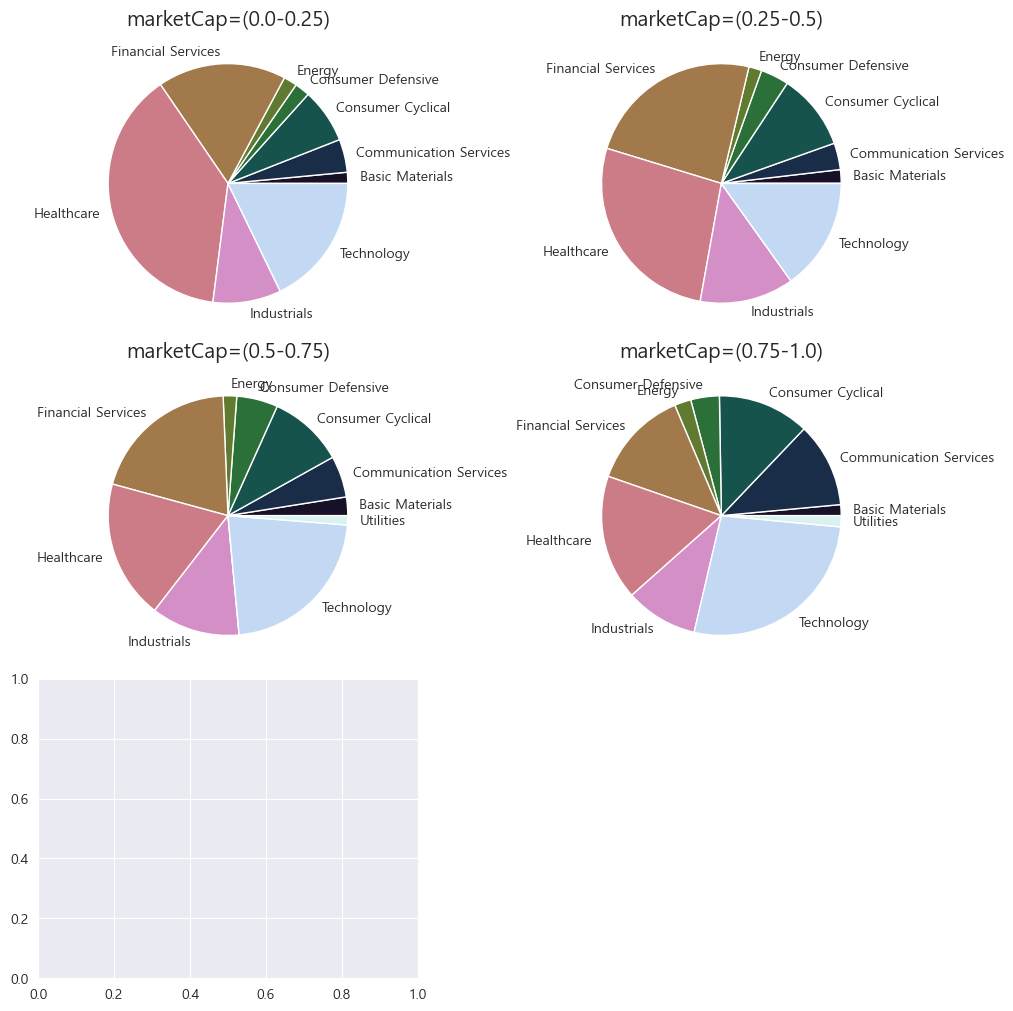

In [109]:
from core.evaluate import show_selection, prepare_canvas
import matplotlib.pyplot as plt
import math

for idx, strategist in enumerate(strategist_list):
    plt.subplot(math.ceil(len(strategist_list) / 2), 2, idx + 1)
    show_selection(strategist, db_interface, radius=1, fontsize=15, labeldistacne=1.1)

### 다음은, 각 전략별로 기간동안 무엇을 했는지 봐볼게요.
* 우리는 기간마다 전부 팔고, 다시 기준에 부합하는 주식을 새로 고르기 때문에 (rebalancing) 전략은 같아도 선택되는 주식은 늘 변할 거에요 !
* 왜냐면, 시가 총액 / PBR / PER 등등 매일 혹은 매 분기마다 변하는 것이니까요.

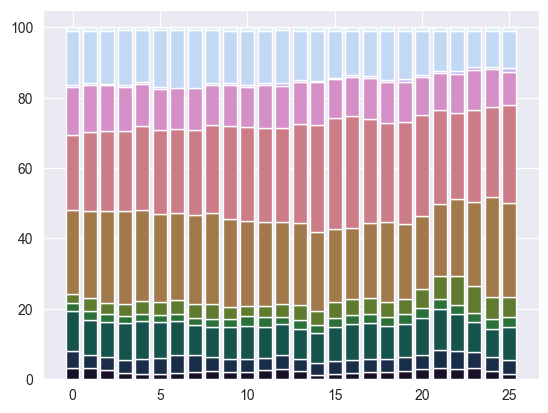

In [6]:
# TODO mdates applying
from core.evaluate import extract_sector_count_from_segment, SECTOR_COLOR_MAP

for idx, segment in enumerate(strategist_list[0].state[1:]):
    sector_counts = extract_sector_count_from_segment(segment, db_interface)
    bottom = 0
    for index, sector in sector_counts.items():
        try:
            color = SECTOR_COLOR_MAP[index]
            height = sector
            plt.bar(idx, height, bottom=bottom, color=color)
            bottom += height
        except:
            continue

# 자, 그럼이제 우리 각 전략들을 고수했을때 우리 잔고는 어떻게 되었는지 생각해볼까요?
* 처음 잔고를 1원이라고 가정해볼게요. 과연 이 기간동안 최종 잔고는 어떻게 되었을까요? 🤔
* 첫번째 그림이 각 전략을 계속 고수했을떄 잔고 상태입니다.

In [100]:
from core.evaluate import get_all_symbols_price_history, estimate_price_history

df_all_price_history = get_all_symbols_price_history(strategist_list[-1], db_interface)
price_history_dict = {strategist.name: estimate_price_history(strategist, df_all_price_history) for strategist in
                      strategist_list}


1398 / 1399 symbols have price history


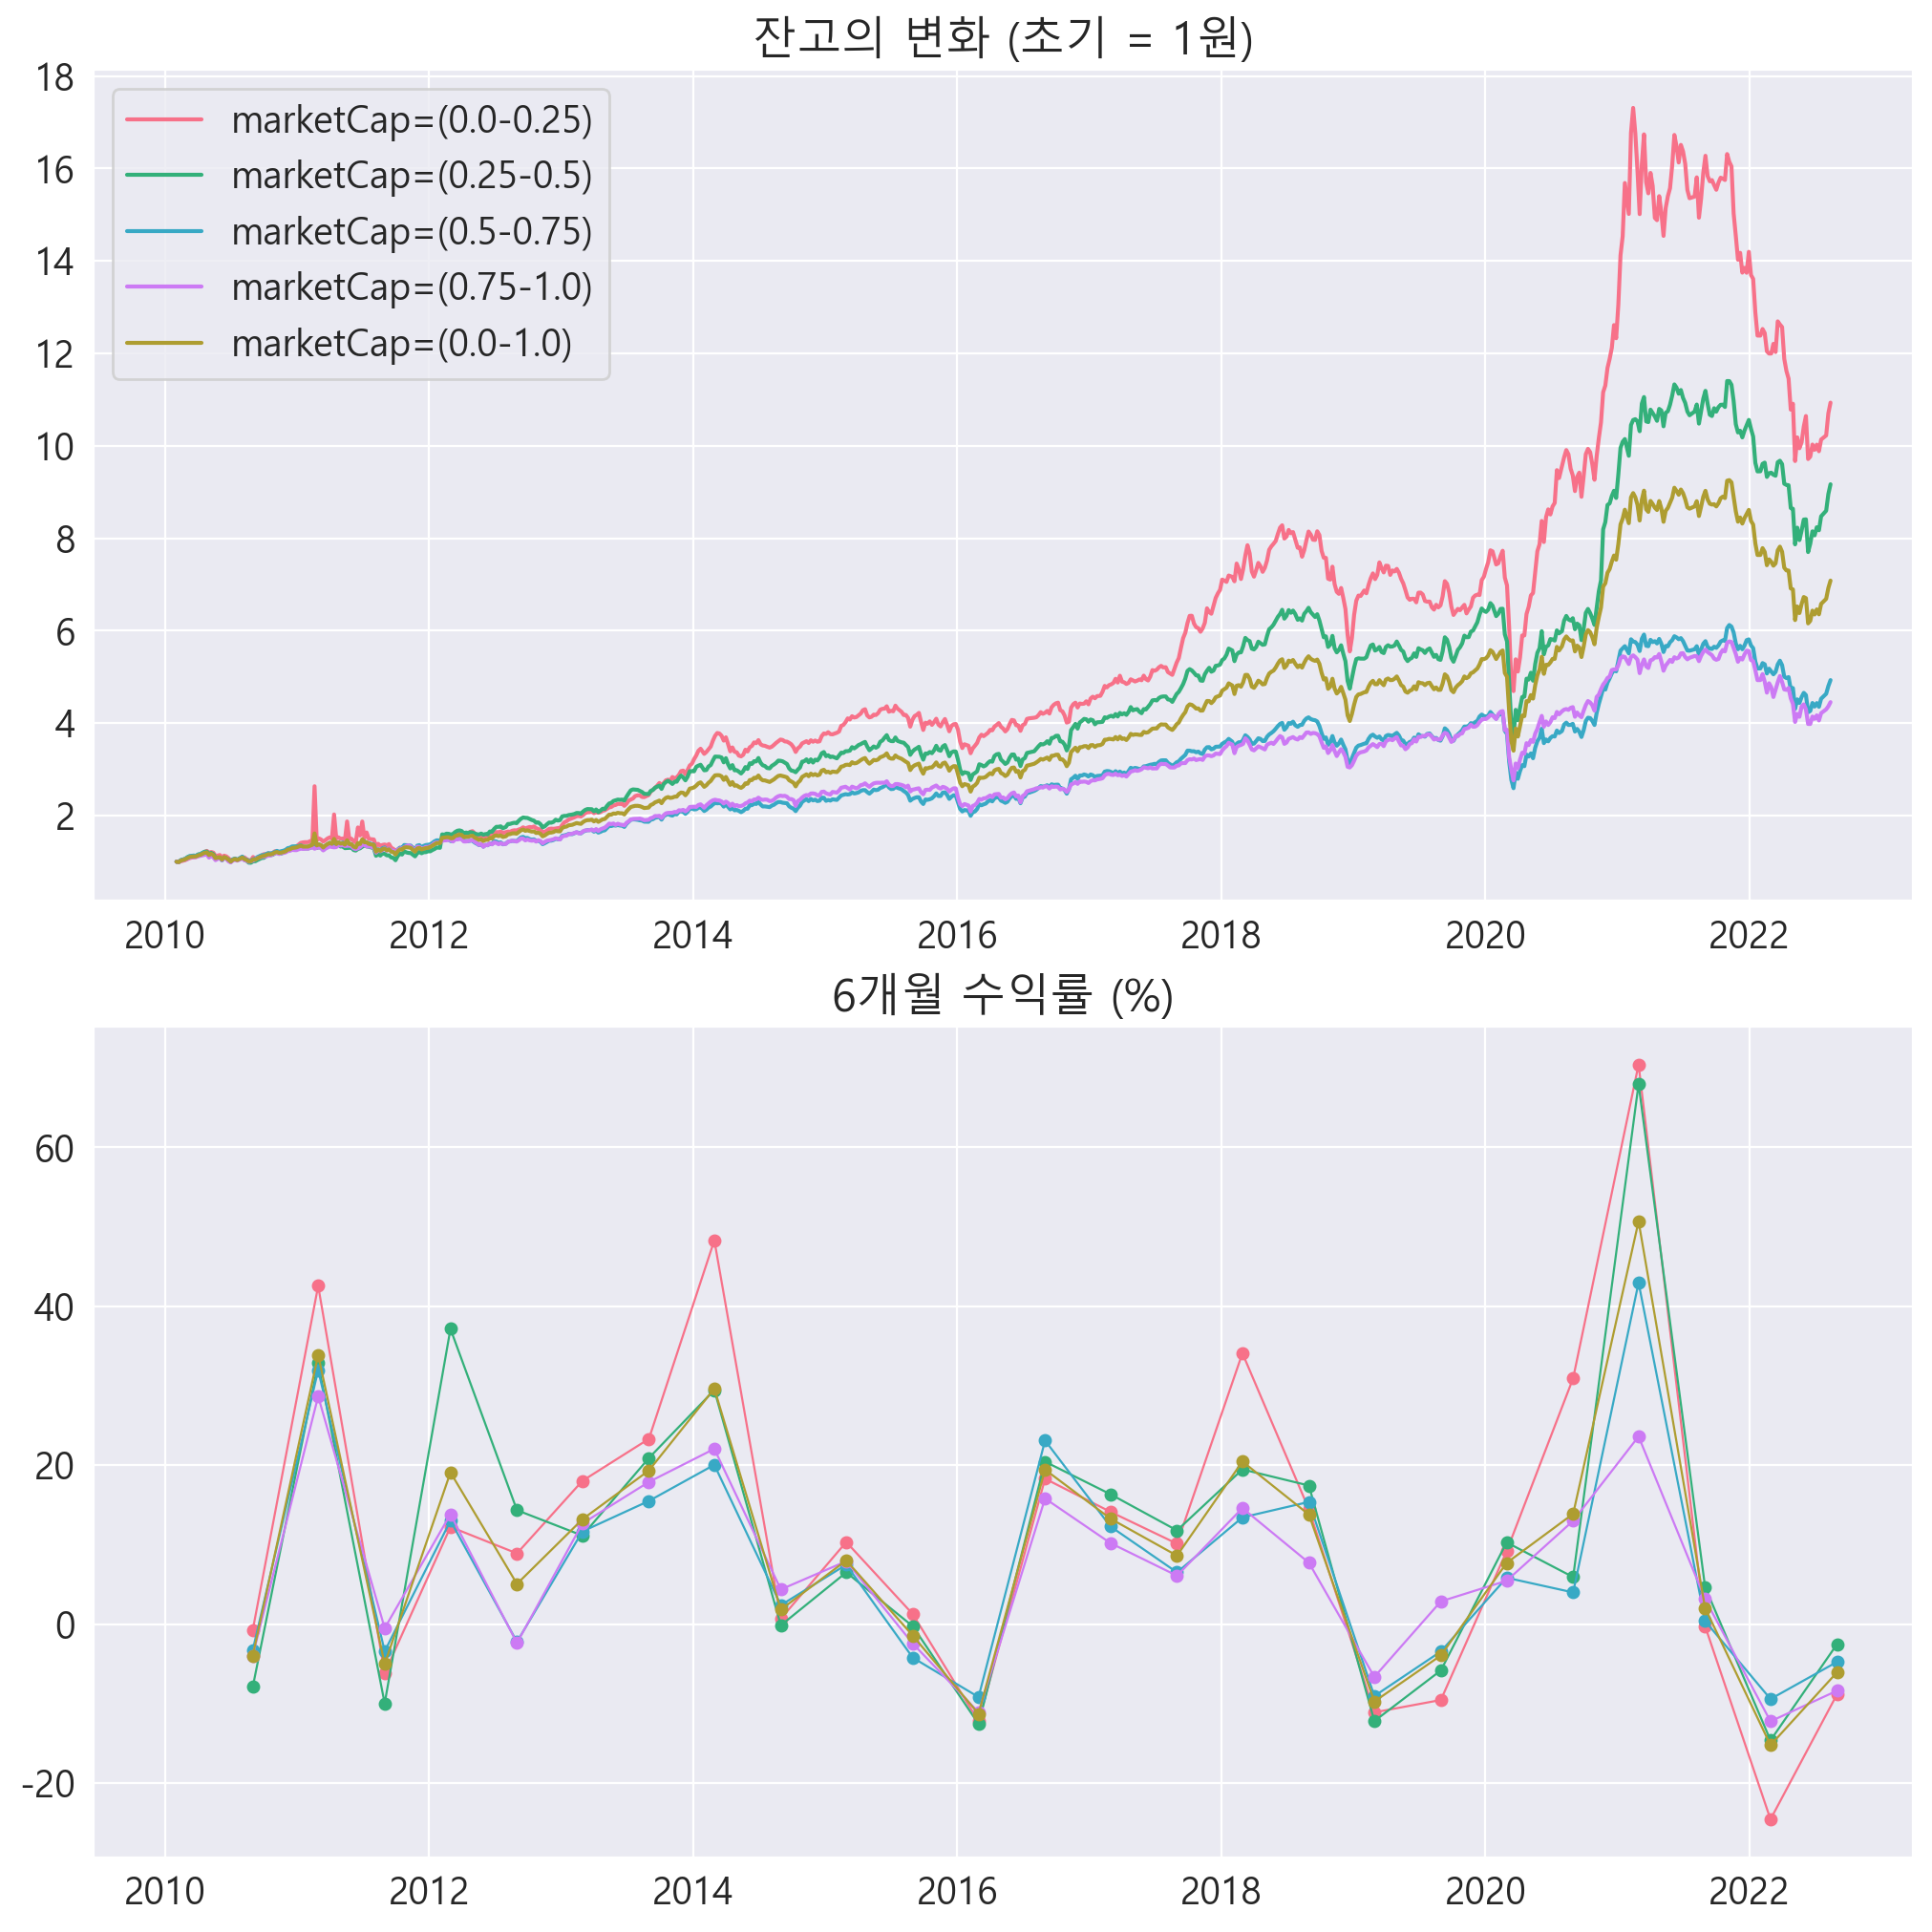

In [108]:
from core.evaluate import generate_sector_color, prepare_canvas
import matplotlib.pyplot as plt

prepare_canvas(fontsize=12)

period = '6M'
colors = generate_sector_color(list(price_history_dict.keys()), "husl")
for k, v in price_history_dict.items():
    plt.subplot(2, 1, 1)
    plt.plot(v, label=k, color=colors[k])
    x_lim = plt.gca().get_xlim()
    plt.title('잔고의 변화 (초기 = 1원)')
    plt.legend()

    plt.subplot(2, 1, 2)
    pct_change = v.resample(period).last().pct_change() * 100
    plt.plot(pct_change, 'o-', color=colors[k], markersize=4, linewidth=0.8)
    plt.title(f'{period[:-1]}개월 수익률 (%)')
    plt.gca().set_xlim(x_lim)

In [65]:
df_all_price_history = get_all_symbols_price_history(strategist_list[0], db_interface)
df_all_price_history_resample = df_all_price_history.resample('6D').mean()  # TODO param

658 / 658 symbols have price history


here


KeyError: None

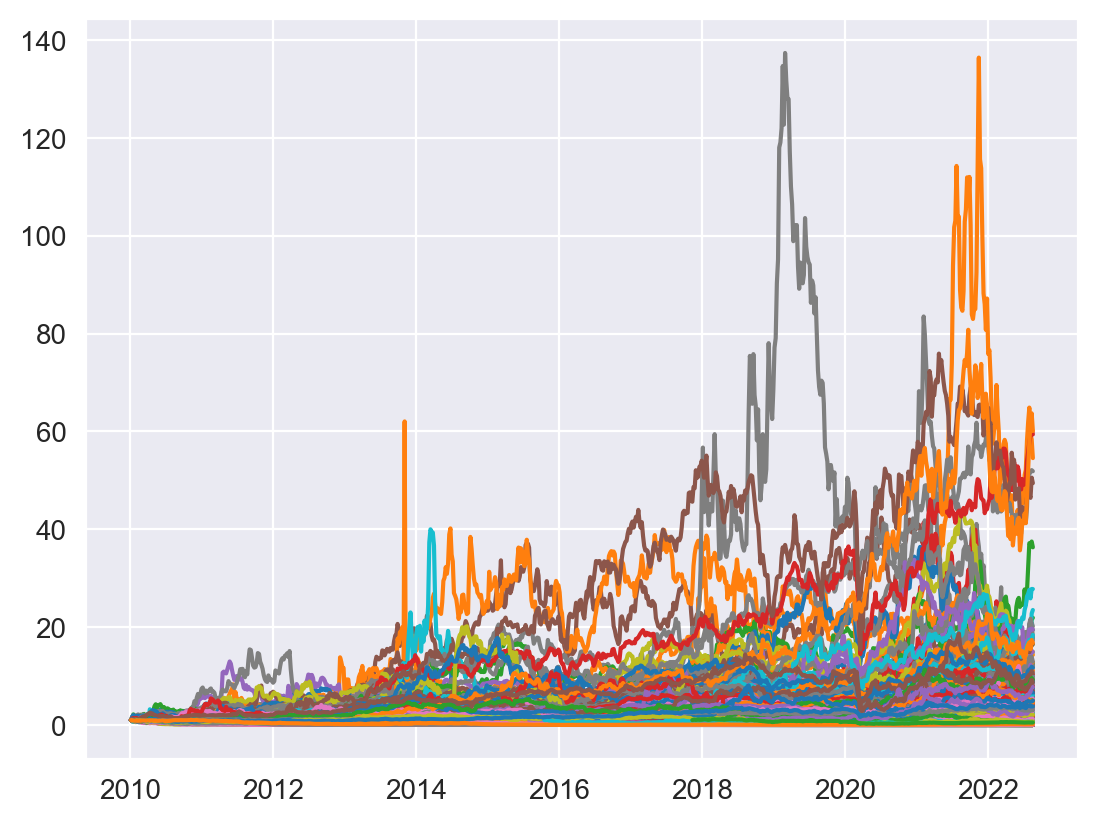

In [98]:

averaged_accumulation = pd.Series(index=df_all_price_history_resample.columns, dtype=float)
return_ratio_dict = pd.Series(index=df_all_price_history_resample.columns, dtype=float)
for column in df_all_price_history_resample:
    column_series = df_all_price_history_resample[column]
    valid_horizon_start = column_series.first_valid_index()
    valid_horizon_end = column_series.last_valid_index()
    initial_value = column_series[valid_horizon_start]
    final_value = column_series[valid_horizon_end]
    if column == 'SBLK':
        print("here")
    column_series /= initial_value
    if (valid_horizon_end - valid_horizon_start).days > 1:
        integration = column_series.sum() / (valid_horizon_end - valid_horizon_start).days
        averaged_accumulation[column] = integration
        return_ratio_dict[column] = (final_value - initial_value) / initial_value
        plt.plot(column_series)


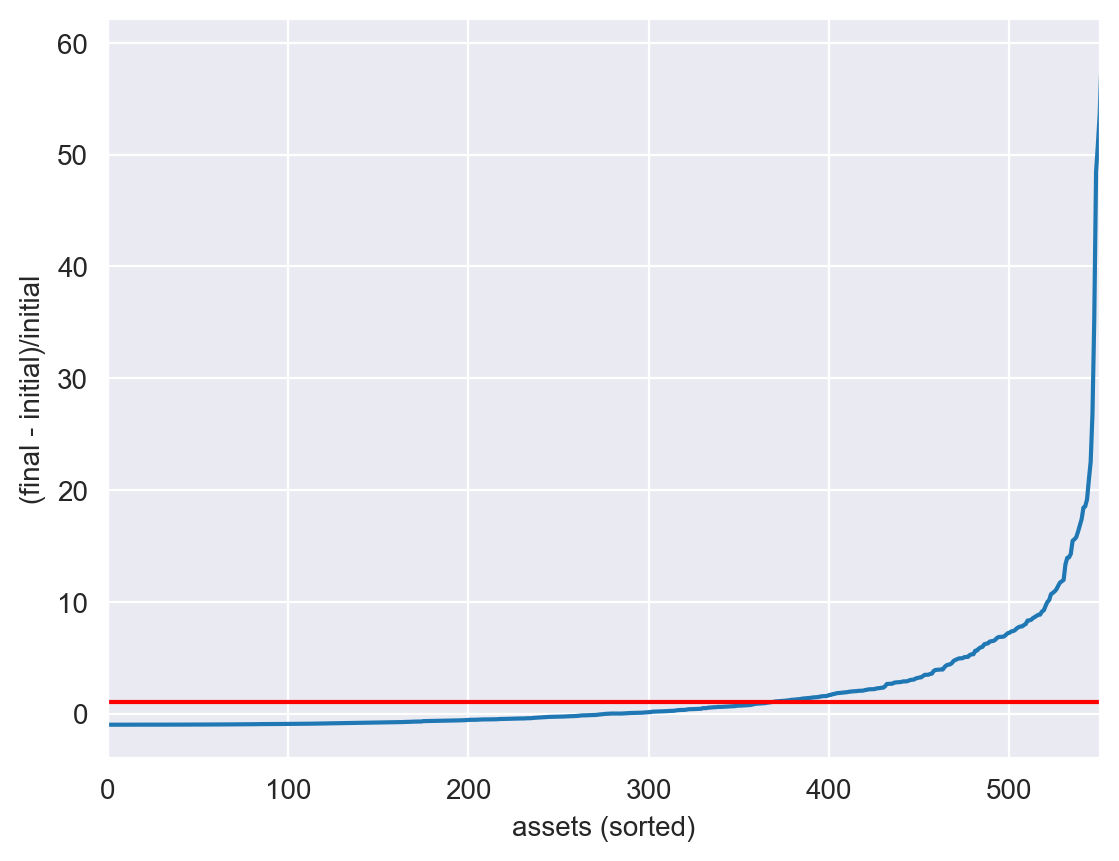

In [97]:
return_ratio_list = return_ratio_dict.values
return_ratio_list.sort()
plt.plot(return_ratio_list)
plt.hlines(1, 0, 550, color='r')
plt.xlim([0, 550])
plt.xlabel('assets (sorted)')
plt.ylabel('(final - initial)/initial')
plt.show()


In [90]:
# 섹터 별 수익률

658